# Assignment 4: Fun with words
## CS 533: Intro to Data Science
Kevin Kirchoff<br>
Taso Kinnas

## Load Libraries

In [1]:
library(tidyverse)
library(dbplyr)
library(tidytext)
#install.packages("RSQLite",repos = "http://cran.us.r-project.org")
library(plotROC)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'dbplyr'

The following objects are masked from 'package:dplyr':

    ident, sql



## Load Data

In [2]:
db = src_sqlite("data/academic-journals/ejc-trimmed.db")
data(stop_words)

In [3]:
articles = db %>% tbl("articles")
journals = db %>% tbl("journals")

## Preliminary Exploration

### 1. Plot a use-by-rank distribution of the words used in the corpus, separately for each journal. You should see a Ziph distribution, like in Text Mining.

In [4]:
# Tokenize the words
journal_df = db %>% tbl("journals") %>%
    inner_join(db %>% tbl("articles")) %>%
    filter(year >= 1895 && year <= 1905) %>%
    select(name, article_id, journal, year, text) %>%
    collect() %>%
    unnest_tokens(word, text)

# remove stop words
# (common words that very likely won't tell us anything)
journal_df = journal_df %>%
    anti_join(stop_words)

head(journal_df)

Joining, by = "jnl_id"
Joining, by = "word"


name,article_id,journal,year,word
AmPhil,635,Transactions of the American Philosophical Society,1895,american
AmPhil,635,Transactions of the American Philosophical Society,1895,ph
AmPhil,635,Transactions of the American Philosophical Society,1895,ilosoph
AmPhil,635,Transactions of the American Philosophical Society,1895,ical
AmPhil,635,Transactions of the American Philosophical Society,1895,society
AmPhil,635,Transactions of the American Philosophical Society,1895,held


In [5]:
# count of words by journal
journal_words = journal_df %>% 
    count(name, journal, word, sort=TRUE) %>%
    ungroup()
head(journal_words)

# count of words by journal and year
journal_words2 = journal_df %>% 
    count(year, name, journal, word, sort=TRUE) %>%
    ungroup()
head(journal_words2)

name,journal,word,n
Science,Science,science,55848
Science,Science,professor,47311
Science,Science,university,41909
Science,Science,dr,38139
Science,Science,time,23584
Science,Science,scientific,21730


year,name,journal,word,n
1902,Science,Science,science,6441
1901,Science,Science,science,6329
1901,Science,Science,professor,6270
1901,Science,Science,university,5685
1897,Science,Science,science,5446
1896,Science,Science,science,5329


In [6]:
# total words per journal
total_words = journal_words %>%
    group_by(name) %>%
    summarize(total = sum(n))
head(total_words)

name,total
AdvPeace,1191251
AmPhil,317543
AmRev,3150211
Science,8368026


In [7]:
# join the two count types to get the ratio of a word
# within a journal against the total count of words
# in the journal
word_collection = left_join(journal_words, total_words)
head(word_collection)

# join the two count types to get the ratio of a word
# within a journal against the total count of words
# in the journal by year
word_collection2 = left_join(journal_words2, total_words)
head(word_collection2)

Joining, by = "name"


name,journal,word,n,total
Science,Science,science,55848,8368026
Science,Science,professor,47311,8368026
Science,Science,university,41909,8368026
Science,Science,dr,38139,8368026
Science,Science,time,23584,8368026
Science,Science,scientific,21730,8368026


Joining, by = "name"


year,name,journal,word,n,total
1902,Science,Science,science,6441,8368026
1901,Science,Science,science,6329,8368026
1901,Science,Science,professor,6270,8368026
1901,Science,Science,university,5685,8368026
1897,Science,Science,science,5446,8368026
1896,Science,Science,science,5329,8368026


In [8]:
#frequency of a word by journal
freq_by_rank = word_collection %>%
    group_by(name) %>% 
    mutate(rank = row_number(), term_frequency = n/total) %>%
    filter(journal != "NA")
head(freq_by_rank)

name,journal,word,n,total,rank,term_frequency
Science,Science,science,55848,8368026,1,0.006673975
Science,Science,professor,47311,8368026,2,0.005653783
Science,Science,university,41909,8368026,3,0.005008230
Science,Science,dr,38139,8368026,4,0.004557706
Science,Science,time,23584,8368026,5,0.002818347
Science,Science,scientific,21730,8368026,6,0.002596789


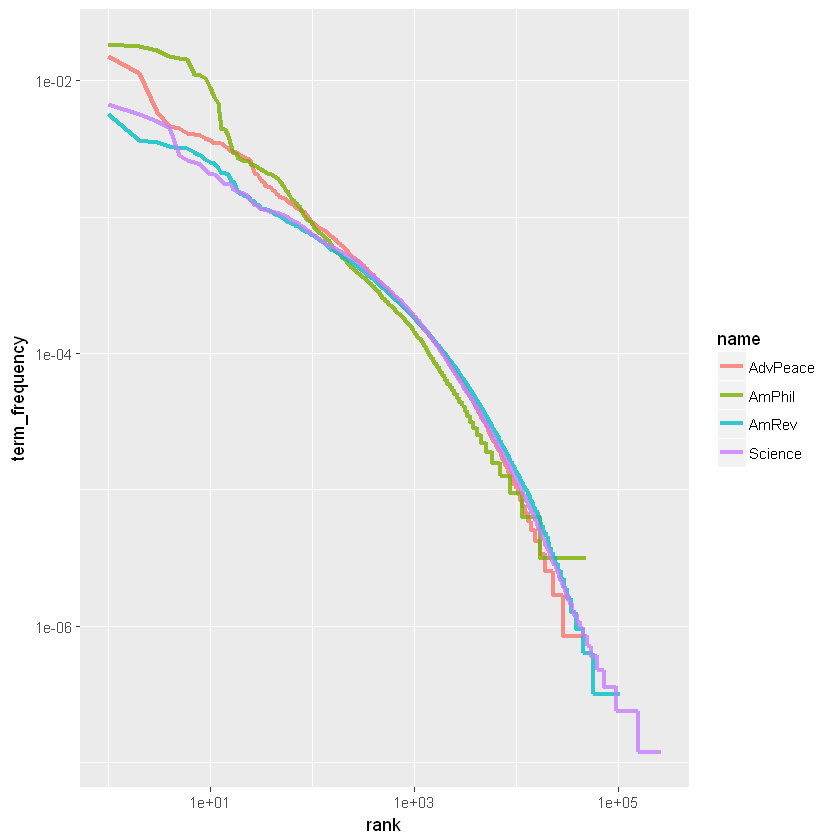

In [9]:
# Zipf's law 
freq_by_rank %>% 
  ggplot(aes(rank, term_frequency, color = name)) + 
  geom_line(size = 1.2, alpha = 0.8) + 
  scale_x_log10() +
  scale_y_log10()

### 2. Show the 10 most common words in each journal.

In [10]:
AdvPeace = arrange(filter(freq_by_rank, rank <11, name=="AdvPeace"), name)
AdvPeace

name,journal,word,n,total,rank,term_frequency
AdvPeace,The Advocate of Peace (1894-1920),peace,17903,1191251,1,0.015028739
AdvPeace,The Advocate of Peace (1894-1920),war,13543,1191251,2,0.011368721
AdvPeace,The Advocate of Peace (1894-1920),mass,6999,1191251,3,0.005875336
AdvPeace,The Advocate of Peace (1894-1920),arbitration,5557,1191251,4,0.004664844
AdvPeace,The Advocate of Peace (1894-1920),society,5315,1191251,5,0.004461696
AdvPeace,The Advocate of Peace (1894-1920),international,4932,1191251,6,0.004140185
AdvPeace,The Advocate of Peace (1894-1920),boston,4816,1191251,7,0.004042809
AdvPeace,The Advocate of Peace (1894-1920),nations,4754,1191251,8,0.003990763
AdvPeace,The Advocate of Peace (1894-1920),world,4501,1191251,9,0.003778381
AdvPeace,The Advocate of Peace (1894-1920),rev,4350,1191251,10,0.003651623


In [11]:
AmPhil = arrange(filter(freq_by_rank, rank <11, name=="AmPhil"), name)
AmPhil

name,journal,word,n,total,rank,term_frequency
AmPhil,Transactions of the American Philosophical Society,2,5865,317543,1,0.018469940
AmPhil,Transactions of the American Philosophical Society,40,5676,317543,2,0.017874745
AmPhil,Transactions of the American Philosophical Society,1,5317,317543,3,0.016744189
AmPhil,Transactions of the American Philosophical Society,6,4762,317543,4,0.014996394
AmPhil,Transactions of the American Philosophical Society,3,4666,317543,5,0.014694073
AmPhil,Transactions of the American Philosophical Society,4,4532,317543,6,0.014272083
AmPhil,Transactions of the American Philosophical Society,5,3549,317543,7,0.011176439
AmPhil,Transactions of the American Philosophical Society,7,3501,317543,8,0.011025278
AmPhil,Transactions of the American Philosophical Society,8,3313,317543,9,0.010433233
AmPhil,Transactions of the American Philosophical Society,9,2845,317543,10,0.008959417


In [12]:
AmRev = arrange(filter(freq_by_rank, rank <11, name=="AmRev"), name)
AmRev

name,journal,word,n,total,rank,term_frequency
AmRev,The North American Review,american,17903,3150211,1,0.005683111
AmRev,The North American Review,time,11563,3150211,2,0.003670548
AmRev,The North American Review,united,11119,3150211,3,0.003529605
AmRev,The North American Review,government,10321,3150211,4,0.003276288
AmRev,The North American Review,north,10111,3150211,5,0.003209626
AmRev,The North American Review,people,10010,3150211,6,0.003177565
AmRev,The North American Review,review,9416,3150211,7,0.002989006
AmRev,The North American Review,country,8874,3150211,8,0.002816954
AmRev,The North American Review,war,8308,3150211,9,0.002637284
AmRev,The North American Review,power,7871,3150211,10,0.002498563


In [13]:
RoyalPhil = arrange(filter(freq_by_rank, rank <11, name=="RoyalPhil"), name)
RoyalPhil

name,journal,word,n,total,rank,term_frequency


In [14]:
Science = arrange(filter(freq_by_rank, rank <11, name=="Science"), name)
Science

name,journal,word,n,total,rank,term_frequency
Science,Science,science,55848,8368026,1,0.006673975
Science,Science,professor,47311,8368026,2,0.005653783
Science,Science,university,41909,8368026,3,0.005008230
Science,Science,dr,38139,8368026,4,0.004557706
Science,Science,time,23584,8368026,5,0.002818347
Science,Science,scientific,21730,8368026,6,0.002596789
Science,Science,american,21238,8368026,7,0.002537994
Science,Science,society,20372,8368026,8,0.002434505
Science,Science,found,18381,8368026,9,0.002196575
Science,Science,vol,17336,8368026,10,0.002071695


## Word Distributions

The main objective of this assignment is to examine the change in language use over time (looking year-over-year).

There are three high-level research questions. You should answer these separately for each journal, and over the enitre corpus.

### 1. What 5–10 words see the greatest increase in use over time?

* Group by journal, year, word...
* Visualize: x-axis:year, y-axis: usage

In [15]:
# getting frequency grouped by year, journal and word
# some tidying for getting increases in word counts over time
word_inc = word_collection2 %>%
    mutate(freq = n/total) %>%
    group_by(year) %>%
    arrange(word, year) %>%
    select(year, name, word, freq)
#head(word_inc, 10)

In [16]:
print("increase in top 10 words for corpus")
word_inc_corpus = word_inc %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(-total)
head(word_inc_corpus, 10)

[1] "increase in top 10 words for corpus"


word,total
peace,0.0013981771
fig,0.0010949623
war,0.0009980114
anid,0.0007678024
deep,0.0007148638
mass,0.0005878213
posterior,0.0005750301
nippur,0.0005726727
science,0.0005556250
cope,0.0005313719


In [17]:
word_inc_overtime_corpus = word_inc %>%
    #filter(name == "AdvPeace") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") 

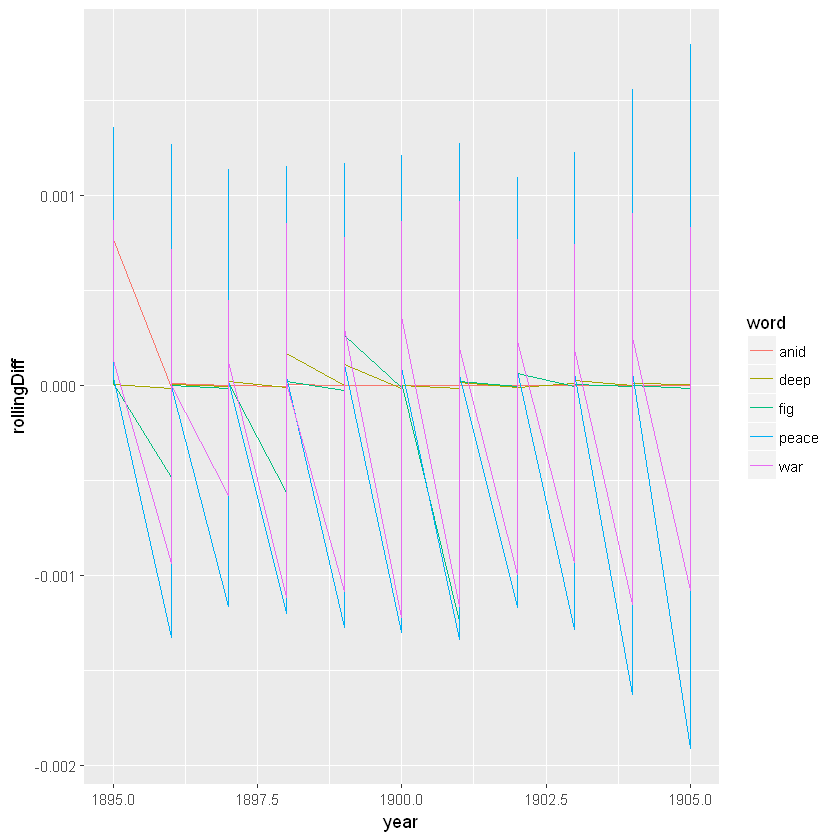

In [18]:
target = c("peace", "fig", "war", "anid" ,"deep")
word_inc_overtime_corpus = word_inc_overtime_corpus %>% 
    filter(word %in% target)
    word_inc_overtime_corpus %>%
    ggplot() + 
        aes(year, rollingDiff, color = word ) +
        geom_line()

In [19]:
print("increase in top 10 words for AdvPeace")
word_inc_AdvPeace = word_inc %>%
    filter(name == "AdvPeace") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(-total)
head(word_inc_AdvPeace, 10)

[1] "increase in top 10 words for AdvPeace"


word,total
1895,1.326337e-04
country,1.200419e-04
life,9.989498e-05
military,9.989498e-05
boys,9.485826e-05
hon,9.485826e-05
lord,8.058755e-05
chicago,7.890864e-05
god,7.890864e-05
army,7.806919e-05


In [20]:
word_inc_overtime_AdvPeace = word_inc %>%
    filter(name == "AdvPeace") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") 

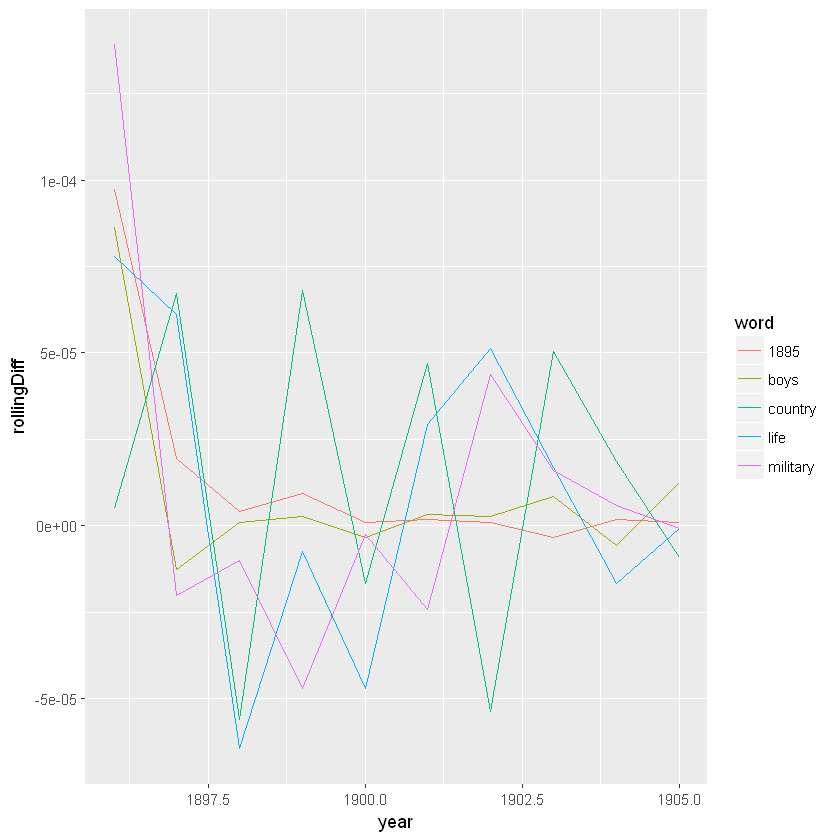

In [21]:
target = c("1895", "country", "life", "military" ,"boys")
word_inc_overtime_AdvPeace = word_inc_overtime_AdvPeace %>% filter(word %in% target)
word_inc_overtime_AdvPeace %>% ggplot() + 
    aes(year, rollingDiff, color = word ) +
    geom_line()

In [22]:
print("increase in top 10 words for AmPhil")
word_inc_AmPhil = word_inc %>%
    filter(name == "AmPhil") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(-total)
head(word_inc_AmPhil, 10)

[1] "increase in top 10 words for AmPhil"


word,total
cos,0.0028279635
sin,0.0025224930
chromosomes,0.0020343701
species,0.0009730966
fig,0.0009132621
anid,0.0007621015
beds,0.0007558032
deep,0.0007148638
3,0.0005857474
4,0.0005542556


In [23]:
word_inc_overtime_AmPhil = word_inc %>%
    filter(name == "AmPhil") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") 

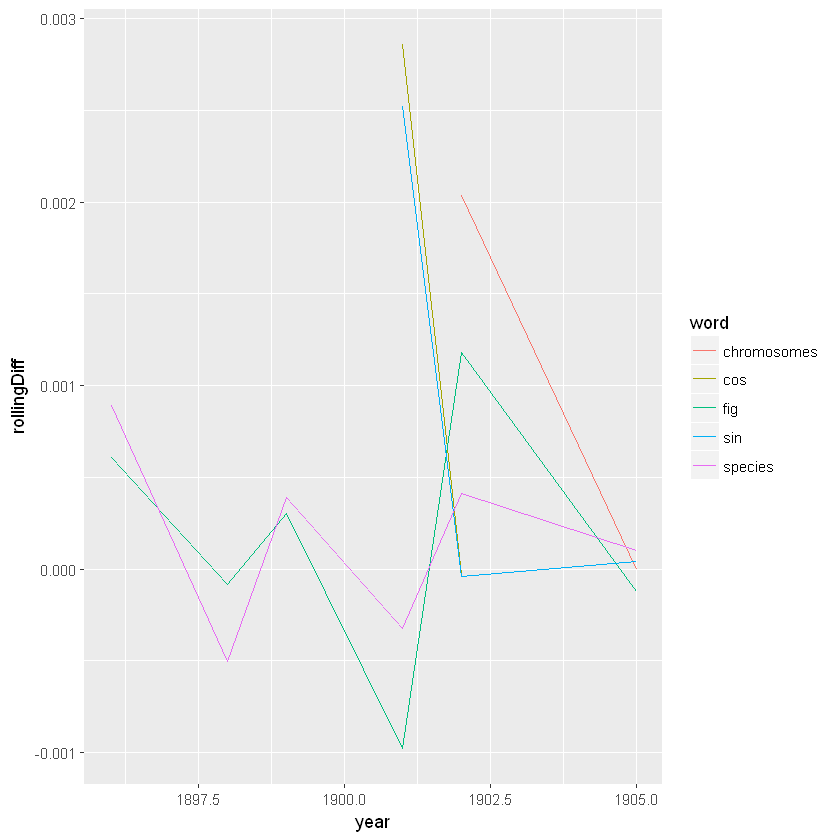

In [24]:
target = c("cos", "sin", "chromosomes", "species" ,"fig")
word_inc_overtime_AmPhil = word_inc_overtime_AmPhil %>% filter(word %in% target)
word_inc_overtime_AmPhil %>% ggplot() + 
    aes(year, rollingDiff, color = word ) +
    geom_line()

In [25]:
print("increase in top 10 words for AmRev")
word_inc_AmRev = word_inc %>%
    filter(name == "AmRev") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(-total)
head(word_inc_AmRev, 10)

[1] "increase in top 10 words for AmRev"


word,total
gold,1.314198e-04
silver,1.130083e-04
money,6.190062e-05
women,6.063086e-05
notes,5.904366e-05
wealth,5.396464e-05
dreyfus,5.269488e-05
louis,5.142513e-05
napoleon,4.825074e-05
currency,4.412403e-05


In [26]:
word_inc_overtime_AmRev = word_inc %>%
    filter(name == "AmRev") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") 

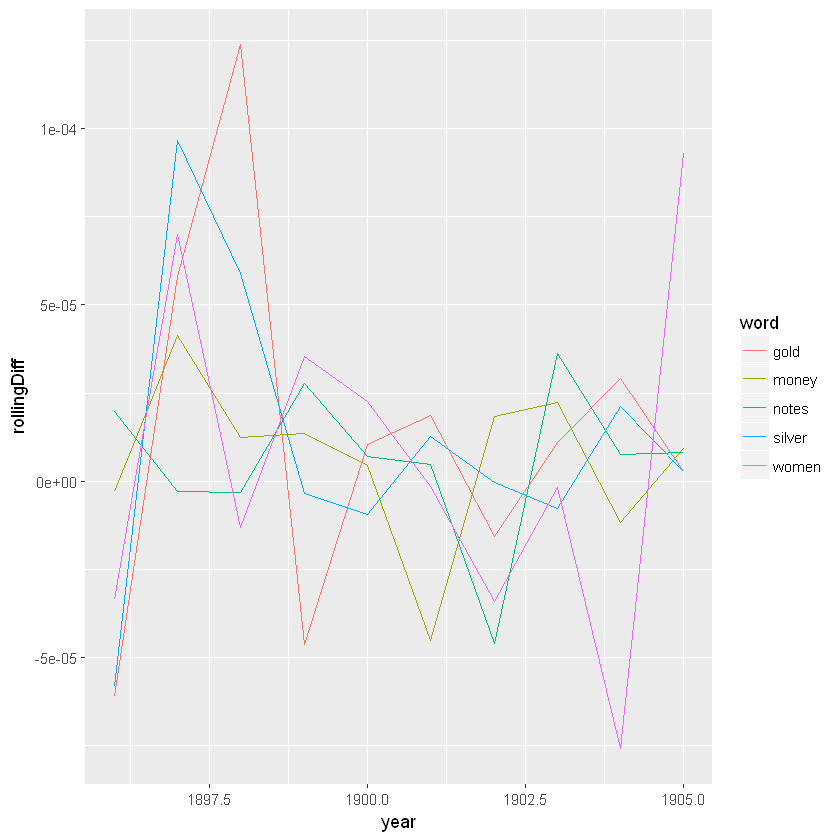

In [27]:
target = c("gold", "silver", "money", "women" ,"notes")
word_inc_overtime_AmRev = word_inc_overtime_AmRev %>% filter(word %in% target)
word_inc_overtime_AmRev %>% ggplot() + 
    aes(year, rollingDiff, color = word ) +
    geom_line()

In [28]:
print("increase in top 10 words for RoyalPhil")
word_inc_RoyalPhil = word_inc %>%
    filter(name == "RoyalPhil") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(-total)
head(word_inc_RoyalPhil, 10)

[1] "increase in top 10 words for RoyalPhil"


word,total


In [29]:
word_inc_overtime_RoyalPhil = word_inc %>%
    filter(name == "RoyalPhil") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") 

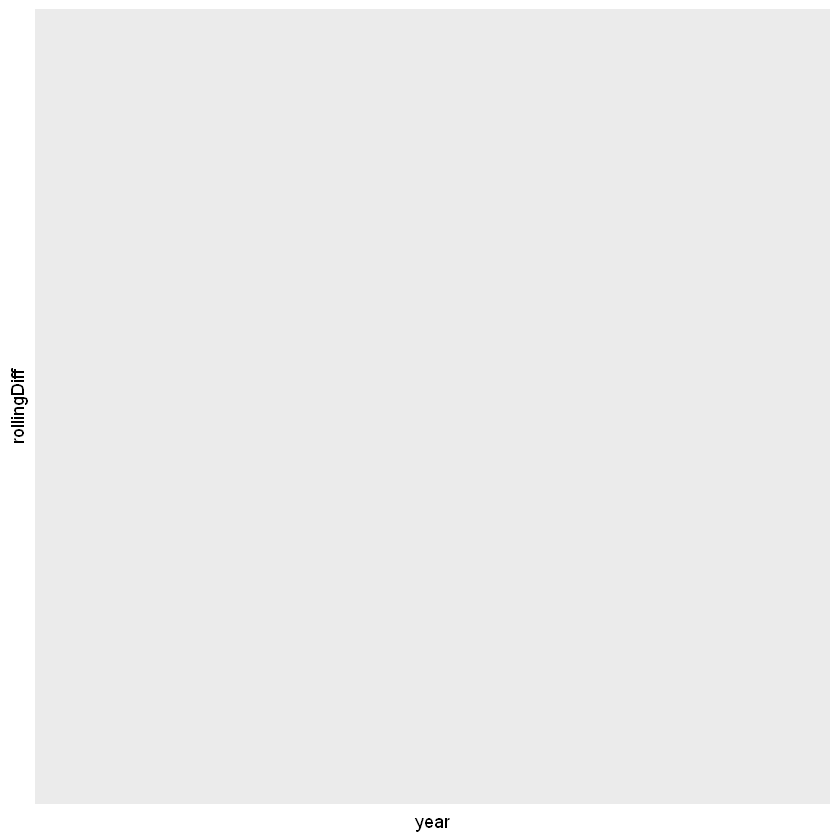

In [30]:
target = c("1", "98", "5", "2" ,"15")
word_inc_overtime_RoyalPhil = word_inc_overtime_RoyalPhil %>% filter(word %in% target)
word_inc_overtime_RoyalPhil %>% ggplot() + 
    aes(year, rollingDiff, color = word ) +
    geom_line()

In [31]:
print("increase in top 10 words for Science")
word_inc_Science = word_inc %>%
    filter(name == "Science") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(-total)
head(word_inc_Science, 10)

[1] "increase in top 10 words for Science"


word,total
1895,2.856110e-04
prof,1.655110e-04
1894,9.201692e-05
pp,8.412976e-05
science,7.923016e-05
ii,7.875215e-05
scientific,6.668239e-05
current,3.967483e-05
book,3.919682e-05
literature,3.668727e-05


In [32]:
word_inc_overtime_Science = word_inc %>%
    filter(name == "Science") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") 

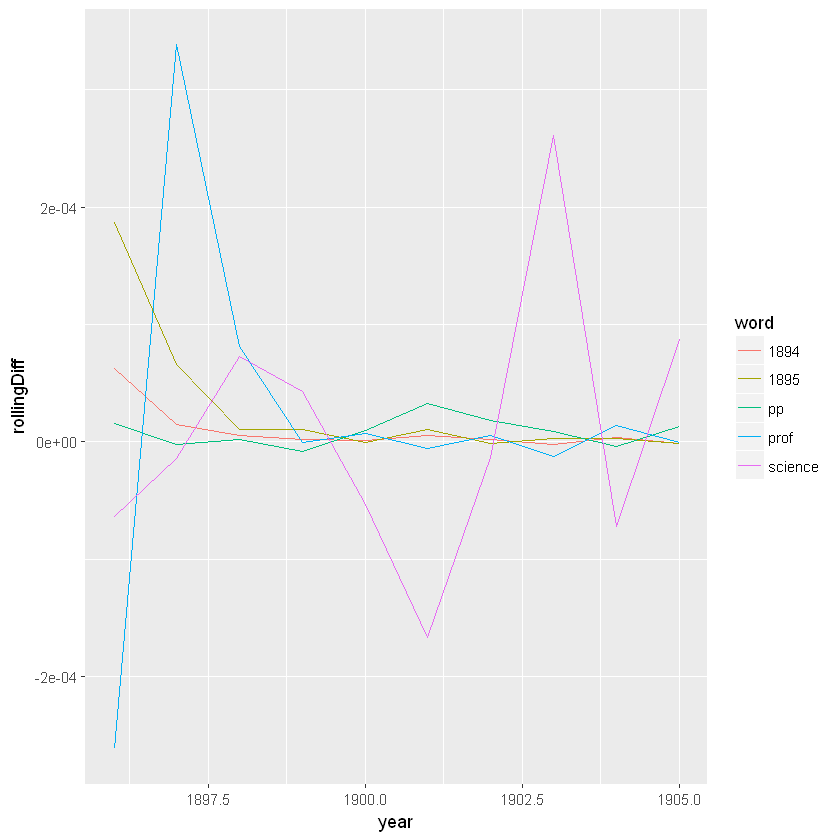

In [33]:
target = c("1895", "prof", "1894", "pp", "science")
word_inc_overtime_Science = word_inc_overtime_Science %>% filter(word %in% target)
word_inc_overtime_Science %>% ggplot() + 
    aes(year, rollingDiff, color = word ) +
    geom_line()

### 2. What 5–10 words see the greatest decrease in use over time?

In [34]:
print("decrease in top 10 words for corpus")
word_inc_corpus = word_inc %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(total)
head(word_inc_corpus, 10)

[1] "decrease in top 10 words for corpus"


word,total
spermatogonic,-0.0003295884
congress,-0.0002793733
president,-0.0002463701
3.21,-0.0002393377
3.08,-0.0002383853
3.12,-0.0002264235
biv,-0.0002201251
3.10,-0.0002077264
3.19,-0.0002077264
3.23,-0.0002076069


In [35]:
print("decrease in top 10 words for AdvPeace")
word_inc_AdvPeace = word_inc %>%
    filter(name == "AdvPeace") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(total)
head(word_inc_AdvPeace, 10)

[1] "decrease in top 10 words for AdvPeace"


word,total
peace,-0.0005145851
hague,-0.0003089189
international,-0.0003013639
conference,-0.0002467994
st,-0.0002358865
cts,-0.0002023083
hundred,-0.0001897165
world,-0.0001838403
price,-0.0001737669
treaties,-0.0001578173


In [36]:
print("decrease in top 10 words for AmPhil")
word_inc_AmPhil = word_inc %>%
    filter(name == "AmPhil") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(total)
head(word_inc_AmPhil, 10)

[1] "decrease in top 10 words for AmPhil"


word,total
40,-0.0096585344
36,-0.0011242572
42,-0.0010864670
24,-0.0010833178
37,-0.0010833178
34,-0.0009321572
38,-0.0008912179
23,-0.0008786212
30,-0.0008691736
33,-0.0007841458


In [37]:
print("decrease in top 10 words for AmRev")
word_inc_AmRev = word_inc %>%
    filter(name == "AmRev") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(total)
head(word_inc_AmRev, 10)

[1] "decrease in top 10 words for AmRev"


word,total
american,-1.815751e-04
government,-1.726868e-04
commission,-1.168176e-04
war,-1.161827e-04
rates,-1.104688e-04
united,-1.066595e-04
tariff,-1.018979e-04
foreign,-9.999330e-05
law,-9.808867e-05
german,-9.396196e-05


In [38]:
print("decrease in top 10 words for RoyalPhil")
word_inc_RoyalPhil = word_inc %>%
    filter(name == "RoyalPhil") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(total)
head(word_inc_RoyalPhil, 10)

[1] "decrease in top 10 words for RoyalPhil"


word,total


In [39]:
print("decrease in top 10 words for Science")
word_inc_Science = word_inc %>%
    filter(name == "Science") %>%
    group_by(word) %>%
    mutate(rollingDiff = lag(freq) - freq) %>%
    filter(rollingDiff != "NA") %>% 
    summarize(total = sum(rollingDiff)) %>%
    arrange(total)
head(word_inc_Science, 10)

[1] "decrease in top 10 words for Science"


word,total
1905,-2.458166e-04
university,-2.368539e-04
professor,-2.202431e-04
1,-1.361133e-04
dr,-1.074327e-04
species,-9.954558e-05
1904,-9.619951e-05
whieh,-8.651981e-05
president,-8.078369e-05
college,-7.851314e-05


### 3. What 5–10 words are the most consistently frequently used?

In [40]:
print("The 5–10 words most consistently frequently used in Corpus")
word_mean = word_collection2 %>%
    mutate(freq = n/total) %>%
    group_by(word) %>%
    arrange(word) %>%
    select(year, name, word, freq) %>%
    summarize(mean = mean(freq)) %>%
    arrange(-mean)
head(word_mean, 10)

[1] "The 510 words most consistently frequently used in Corpus"


word,mean
2,0.0005210843
1,0.0004949232
40,0.0004684729
peace,0.0004662643
monaster,0.0004408852
3,0.0004226637
4,0.0004058836
6,0.0004056983
war,0.0004040699
5,0.0003364452


In [41]:
print("The 5–10 words most consistently frequently used in AdvPeace")
word_mean_AdvPeace = word_collection2 %>%
    mutate(freq = n/total) %>%
    filter(name == "AdvPeace") %>%
    group_by(word) %>%
    arrange(word) %>%
    select(year, name, word, freq) %>%
    summarize(mean = mean(freq)) %>%
    arrange(-mean)
head(word_mean_AdvPeace, 10)

[1] "The 510 words most consistently frequently used in AdvPeace"


word,mean
peace,0.0013662490
war,0.0010335201
mass,0.0005341215
arbitration,0.0004240767
society,0.0004056087
international,0.0003763805
boston,0.0003675281
nations,0.0003627966
world,0.0003434892
rev,0.0003319658


In [42]:
print("The 5–10 words most consistently frequently used in AmPhil")
word_mean_AmPhil = word_collection2 %>%
    mutate(freq = n/total) %>%
    filter(name == "AmPhil") %>%
    group_by(word) %>%
    arrange(word) %>%
    select(year, name, word, freq) %>%
    summarize(mean = mean(freq)) %>%
    arrange(-mean)
head(word_mean_AmPhil, 10)

[1] "The 510 words most consistently frequently used in AmPhil"


word,mean
40,0.002979124
2,0.002638563
1,0.002392027
6,0.002142342
3,0.002099153
4,0.002038869
5,0.001596634
chromatin,0.001587187
7,0.001575040
8,0.001490462


In [43]:
print("The 5–10 words most consistently frequently used in AmRev")
word_mean_AmRev = word_collection2 %>%
    mutate(freq = n/total) %>%
    filter(name == "AmRev") %>%
    group_by(word) %>%
    arrange(word) %>%
    select(year, name, word, freq) %>%
    summarize(mean = mean(freq)) %>%
    arrange(-mean)
head(word_mean_AmRev, 10)

[1] "The 510 words most consistently frequently used in AmRev"


word,mean
american,0.0005166465
time,0.0003336862
united,0.0003208732
government,0.0002978444
north,0.0002917842
people,0.0002888695
review,0.0002717278
strether,0.0002647442
country,0.0002560867
war,0.0002397531


In [44]:
print("The 5–10 words most consistently frequently used in RoyalPhil")
word_mean_RoyalPhil = word_collection2 %>%
    mutate(freq = n/total) %>%
    filter(name == "RoyalPhil") %>%
    group_by(word) %>%
    arrange(word) %>%
    select(year, name, word, freq) %>%
    summarize(mean = mean(freq)) %>%
    arrange(-mean)
head(word_mean_RoyalPhil, 10)

[1] "The 510 words most consistently frequently used in RoyalPhil"


word,mean


In [45]:
print("The 5–10 words most consistently frequently used in Science")
word_mean_Science = word_collection2 %>%
    mutate(freq = n/total) %>%
    filter(name == "Science") %>%
    group_by(word) %>%
    arrange(word) %>%
    select(year, name, word, freq) %>%
    summarize(mean = mean(freq)) %>%
    arrange(-mean)
head(word_mean_Science, 10)

[1] "The 510 words most consistently frequently used in Science"


word,mean
science,0.0006067250
professor,0.0005139802
university,0.0004552936
dr,0.0004143369
time,0.0002562134
scientific,0.0002360718
american,0.0002307267
society,0.0002213186
found,0.0001996887
vol,0.0001883359


## Text Similarity

### 1.  What two journals are the most similar? Which two are the least similar?

In [46]:
# group by name, get term frequency
journal_tf = freq_by_rank %>%
    group_by(name) %>%
    mutate(tf = n / sum(n))
#head(journal_tf)

In [47]:
# Error showed up on larger time frames...

# join journal_tf to journals
# spread to get matrix of frequencies
term_freqs = journal_tf %>%
    inner_join(journals, copy=TRUE) %>%
    select(name, word, tf) %>%
    spread(name, tf, fill=0)
#head(term_freqs)

Joining, by = "name"


### Here we can see the two most similar journals are AmPhil and AdvPeace
### The two least similar jouranals are AmRev and AmPil
Note: do to issues with epanding the timefram, this datafrme won't produce.  We ran out of time to debug the issue and therefore not sure how RoyalPhil plays into this.

In [48]:
# create a matrix of frequency differences between journals
# This shows the two most similar journals are:
# The two least similar journals are: 
term_freqs %>% select(-word) %>% cor()

,AdvPeace,AmPhil,AmRev,Science
AdvPeace,1.0000000,0.0995707,0.6184265,0.3705414
AmPhil,0.0995707,1.0000000,0.1042758,0.2347636
AmRev,0.6184265,0.1042758,1.0000000,0.5451200
Science,0.3705414,0.2347636,0.5451200,1.0000000


## Divergence Over Time

In [49]:
# TODO: make text_divergence function.  See assignment notes
text_divergene = function(P,Q){
    total = sum(Q | P)
    qTotal = sum(Q)
    pTotal = sum(P)
    
    DPQ =  -sum(P[t] *log2(Q[t]/P[t]))
    
}


sim_over_time = word_inc %>%
    group_by(name, year, word) %>%
    summarize(count = n()) %>%
    spread(name, count, fill=0) %>%
    group_by(year) %>%
    summarize(divergence = text_divergence(AmPhil, RoyalPhil))

ERROR: Error in summarise_impl(.data, dots): Evaluation error: could not find function "text_divergence".
